In [1]:
import numpy as np
import pandas as pd

import itertools

import torch
import torch.nn as nn
import torch.optim as optim

from hypll import nn as hnn
from hypll.tensors import TangentTensor
from hypll.optim import RiemannianAdam
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder

In [2]:
import sys
sys.path.append('../')
import util

In [3]:
df_train_X = pd.read_csv('../data/beer_features_train.csv', index_col=0).drop(columns=['tasting_category_fine'])
df_train_y = pd.read_csv('../data/beer_labels_panel_train.csv', index_col=0)[['overall', 'tasting_category_fine']]
df_val_X = pd.read_csv('../data/beer_features_train.csv', index_col=0).drop(columns=['tasting_category_fine'])
df_val_y = pd.read_csv('../data/beer_labels_panel_train.csv', index_col=0)[['overall', 'tasting_category_fine']]
df_test_X = pd.read_csv('../data/beer_features_test.csv', index_col=0).drop(columns=['tasting_category_fine'])
df_test_y = pd.read_csv('../data/beer_labels_panel_test.csv', index_col=0)[['overall', 'tasting_category_fine']]

train_X = df_train_X.values
train_y = df_train_y.values
val_X = df_val_X.values
val_y = df_val_y.values
test_X = df_test_X.values
test_y = df_test_y.values

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((175, 231), (175, 2), (175, 231), (175, 2), (75, 231), (75, 2))

In [4]:
train_y[:,1] = LabelEncoder().fit_transform(train_y[:,1])
train_y = train_y.astype(np.float32)
val_y[:,1] = LabelEncoder().fit_transform(val_y[:,1])
val_y = val_y.astype(np.float32)
test_y[:,1] = LabelEncoder().fit_transform(test_y[:,1])
test_y = test_y.astype(np.float32)

In [5]:
FOLDS = 5
NUM_SAMPLE_TYPES = len(val_X)
NUM_SAMPLES_PER_TYPE = len(train_X) // NUM_SAMPLE_TYPES

fold_nums = list(range(FOLDS))
[num*NUM_SAMPLE_TYPES for num in fold_nums]
[(num+1)*NUM_SAMPLE_TYPES for num in fold_nums]

val_indices, train_indices = util.get_fold_indices_rand(NUM_SAMPLE_TYPES, NUM_SAMPLES_PER_TYPE, FOLDS)
train_indices
# print(FOLD_INDICES)

[array([  0,   1,   2,   3,   7,   8,   9,  11,  12,  13,  15,  16,  17,
         18,  19,  20,  22,  23,  24,  25,  26,  27,  28,  30,  33,  34,
         35,  36,  38,  39,  41,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  57,  59,  60,  61,  62,  63,  64,  65,
         67,  69,  70,  71,  73,  74,  75,  76,  78,  80,  81,  82,  84,
         85,  86,  87,  88,  89,  91,  92,  93,  94,  95,  96,  97, 101,
        102, 103, 104, 105, 106, 107, 108, 110, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 129, 130, 131,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146,
        147, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161,
        162, 163, 165, 166, 167, 169, 170, 172, 173, 174]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         14,  17,  18,  20,  21,  23,  24,  25,  27,  28,  29,  30,  31,
         32,  33,  34,  35,  37,  38,  39,  40,  41,  42,  43,  

In [6]:
# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

<h1> Hyperbolic </h1>

In [7]:
# Define your MLP model
class HYP_MLP(nn.Module):
    def __init__(self, input_size, regr_output_size, class_output_size, layer_size, num_hidden_layers, manifold):
        super(HYP_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = hnn.HLinear(input_size, layer_size, manifold=manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.hidden_fcs = nn.ModuleList([hnn.HLinear(layer_size, layer_size, manifold=manifold) for _ in range(num_hidden_layers)])
        self.fc_regr_out = hnn.HLinear(layer_size, regr_output_size, manifold=manifold)
        self.fc_class_out = hnn.HLinear(layer_size, class_output_size, manifold=manifold)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)

        regr_out = self.fc_regr_out(x)

        if self.training:
            class_out = self.sigmoid(self.fc_class_out(x).tensor)
            return regr_out, class_out

        return regr_out


# Define training function
def hyp_train_model(model, train_loader, regr_criterion, optimizer, manifold, device, class_criterion=None, class_multiplier=0):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        regr_targets, class_targets = targets[:,[0]], targets[:,1].to(torch.long)

        optimizer.zero_grad()

        tangents = TangentTensor(data=inputs, man_dim=-1, manifold=manifold)
        manifold_inputs = manifold.expmap(tangents)

        regr_outputs, class_outputs = model(manifold_inputs)

        regr_loss = regr_criterion(regr_outputs.tensor, regr_targets)

        class_loss = class_criterion(class_outputs.cpu(), class_targets)

        loss = regr_loss + class_loss * class_multiplier

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

In [8]:
# param_grid = {
#     'class_multiplier': [0.1,0.2,0.4,0.8],
#     'model_type': ['hyp','euc'],
#     'num_hidden_layers': [2,4,8],
#     'layer_size': [2,4,8,16,32,64],
#     'lr': [0.01,0.02,0.03,0.04],
#     'weight_decay': [0.002,0.003,0.004,0.005],
#     'batch_size': [1024],
#     'epochs': [200],
#     'curvature': [-1]
# }
param_grid = {
    'class_multiplier': [0,1],
    'model_type': ['hyp','euc'],
    'num_hidden_layers': [2,8],
    'layer_size': [2,8,64],
    'lr': [0.04],
    'weight_decay': [0.005],
    'batch_size': [1024],
    'epochs': [200],
    'curvature': [-1]
}

param_combinations = list(itertools.product(*param_grid.values()))
len(param_combinations)

24

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_eval_stats = []

for i, params in enumerate(param_combinations):
    print(f'----- Combination {i} -----')
    print(*zip(param_grid.keys(), params))
    class_multiplier, model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params
    val_indices, train_indices = util.get_fold_indices_rand(NUM_SAMPLE_TYPES, NUM_SAMPLES_PER_TYPE, FOLDS)

    for fold, (fold_train_indices, fold_val_indices) in enumerate(zip(train_indices, val_indices)):
        print(f'Fold {fold}')

        fold_train_X = train_X[fold_train_indices]
        fold_train_y = train_y[fold_train_indices]
        fold_val_X   = val_X[fold_val_indices]
        fold_val_y   = val_y[fold_val_indices]

        train_dataset = CustomDataset(fold_train_X, fold_train_y)
        val_dataset = CustomDataset(fold_val_X, fold_val_y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        manifold = PoincareBall(c=Curvature(curvature))

        model = HYP_MLP(input_size=len(df_train_X.columns),
                        regr_output_size=1,
                        class_output_size=len(set(test_y[:,1])),
                        layer_size=layer_size,
                        num_hidden_layers=num_hidden_layers,
                        manifold=manifold).to(device)

        regr_criterion = nn.MSELoss()
        class_criterion = nn.CrossEntropyLoss()

        optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

        eval_stats = {'loss': {'train': [], 'val': []}, 'r2': {'train': [], 'val': []}}

        for epoch in range(epochs):
            eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, regr_criterion, optimizer, manifold, device,
                                                               class_criterion, class_multiplier))

            eval_stats['r2']['val'].append(util.h_evaluate_r2_double_loss(model, val_loader, manifold, device))

        print(eval_stats['r2']['val'])
        param_eval_stats.append(eval_stats)

----- Combination 0 -----
('class_multiplier', 0) ('model_type', 'hyp') ('num_hidden_layers', 2) ('layer_size', 2) ('lr', 0.04) ('weight_decay', 0.005) ('batch_size', 1024) ('epochs', 200) ('curvature', -1)
Fold 0
[-0.01016429021436549, 0.007514783168127037, 0.010855023733300384, 0.01184527418141823, 0.01147270624390273, 0.010489942262269292, 0.00911137312471777, 0.008322660830066941, 0.007859118577719482, 0.007950509733201216, 0.008274483818683454, 0.008477460988628227, 0.008131960755541123, 0.008529631234800883, 0.008629720987959, 0.008939326155055327, 0.008806702589877813, 0.00846595383533355, 0.007966610150708653, 0.007083503386366763, 0.005921539903898987, 0.004595560844961155, 0.003821096990669459, 0.003283836590877609, 0.0023407981579739445, 0.0015377197402459686, -0.002994847710801052, -0.014095667933746725, -0.02362467951945435, -0.025715834068946508, -0.03943618015513617, -0.053681151408073946, -0.04774887678172046, -0.043028994261478104, -0.041084743927747525, -0.04649775858

TO BEAT:

- 0.041: 4,64; 0.02,0.004 (100)

BEST:

First run:

- 0.041, 4,64; 0.02,0.004; 4,0.1,1 (50)
- 0.041, 4,64; 0.02,0.004; 3,0.1,1 (150)
- 0.041, 8,32; 0.02,0.004; 3,0.1,1 (150)
- 0.040, 4,64; 0.02,0.004; 6,0.2,2 (100)
- 0.041, 4,64; 0.02,0.004; 3,0.1,2 (100)
- 0.041, 4,8; 0.02,0.004; 2,0.8,1 (300)


Second run:

- 0.041, 4,64; 0.02,0.004; 4,0.4,1 (50)
- 0.040, 4,64; 0.02,0.004; 3,0.2,3 (100)
- 0.040, 4,64; 0.02,0.004; 6,0.2,2 (100)
- 0.040, 4,64; 0.02,0.004; 3,0.1,2 (100)


Third run:

- 0.040, 4,64; 0.02,0.005; 3,0.2,3 (100)
- 0.040, 4,64; 0.02,0.003; 3,0.1,2 (100)
- 0.040, 4,64; 0.02,0.004; 3,0.2,3 (100)
- 0.040, 4,64; 0.02,0.004; 6,0.2,2 (100)
- 0.040, 4,64; 0.02,0.002; 3,0.1,2 (100)
- 0.041, 8,8; 0.02,0.005; 6,0.2,3 (150)
- 0.041, 8,8; 0.02,0.002; 3,0.2,3 (200)


In [12]:
values = np.array([s['r2']['val'] for s in param_eval_stats])
single_l_vals = values[:len(values)//2]
single_l_vals = single_l_vals.reshape(single_l_vals.shape[0]//3,3,single_l_vals.shape[-1])
double_l_vals = values[len(values)//2:]
double_l_vals = double_l_vals.reshape(double_l_vals.shape[0]//3,3,double_l_vals.shape[-1])

single_l_vals.shape, double_l_vals.shape

((20, 3, 200), (20, 3, 200))

In [29]:
K = 1

single_best_indices = list(reversed(np.argsort(single_l_vals.mean(axis=1)[:,K])))
double_best_indices = list(reversed(np.argsort(double_l_vals.mean(axis=1)[:,K])))

np.set_printoptions(suppress=True)
print(single_l_vals.mean(axis=1)[:,K][single_best_indices])
print(double_l_vals.mean(axis=1)[:,K][double_best_indices])

[ 0.01856986  0.01856986 -0.00559912 -0.00559912 -0.0071669  -0.0071669
 -0.01607585 -0.01607585 -0.05992602 -0.05992602 -0.26839558 -0.26839558
 -0.27195023 -0.27195023 -0.35837199 -0.35837199 -0.87246827 -0.87246827
 -1.18223264 -1.18223264]
[ 0.01901819  0.01901819  0.00220845  0.00220845 -0.00645328 -0.00645328
 -0.01416165 -0.01416165 -0.05036157 -0.05036157 -0.27560286 -0.27560286
 -0.2790843  -0.2790843  -0.33212218 -0.33212218 -0.87844792 -0.87844792
 -1.1897767  -1.1897767 ]


In [41]:
def mean_of_top(arr, n, axis=0):
    # Sort the array along the specified axis and take the last 10 values (highest)
    sorted_arr = np.sort(arr, axis=axis)
    top_values = sorted_arr.take(indices=range(-n, 0), axis=axis)

    # Compute the mean of these 10 values along the specified axis
    mean_top = np.mean(top_values, axis=axis)

    return mean_top

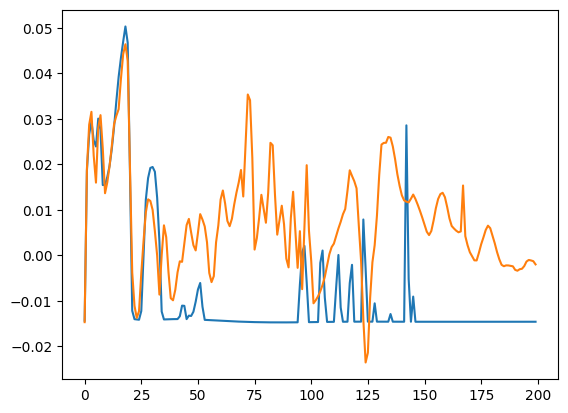

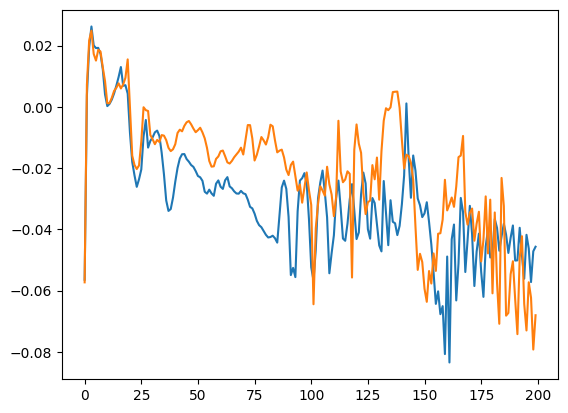

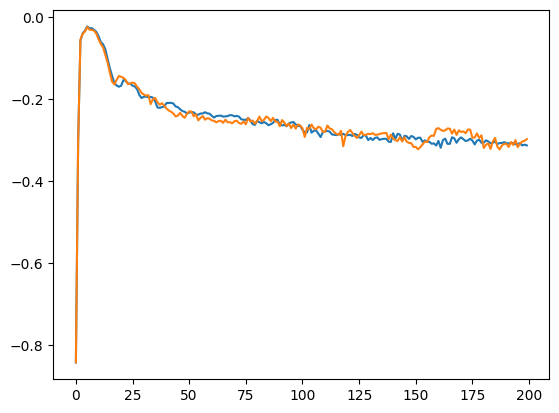

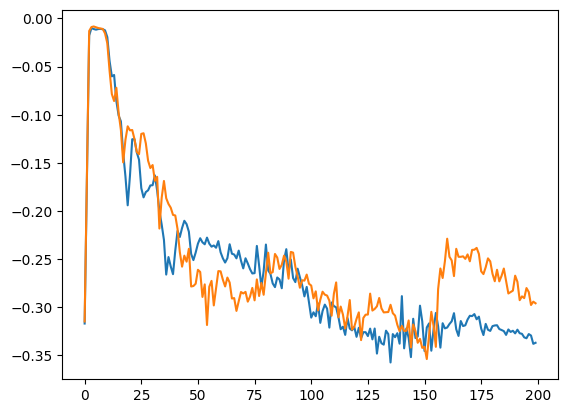

In [44]:
import matplotlib.pyplot as plt

plt.plot(mean_of_top(single_l_vals.mean(axis=1), 1, axis=0))
plt.plot(mean_of_top(double_l_vals.mean(axis=1), 1, axis=0))
plt.show()

plt.plot(mean_of_top(single_l_vals.mean(axis=1), 5, axis=0))
plt.plot(mean_of_top(double_l_vals.mean(axis=1), 5, axis=0))
plt.show()

plt.plot(np.mean(single_l_vals.mean(axis=1), axis=0))
plt.plot(np.mean(double_l_vals.mean(axis=1), axis=0))
plt.show()

plt.plot(np.median(single_l_vals.mean(axis=1), axis=0))
plt.plot(np.median(double_l_vals.mean(axis=1), axis=0))
plt.show()

